In [1]:
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim

import keras
from keras import layers, models
from dataset import get_data
from network import VAE
from training import trainer
from testing import reconstruction, display

### Set hyper-parameters

In [2]:
args = SimpleNamespace(dataset="fmnist")
args.device ="cuda" if torch.cuda.is_available() else "cpu"
args.img = 32       # image size
args.ch = 1         # num of channel
args.batch = 100    # batch size
args.dim = 2        # embedding dimension
args.epoch = 20
args.lr = 5e-4
args.gamma = 500        # weight for reconstruction loss (use bce loss)
print(args)

namespace(dataset='fmnist', device='cuda', img=32, ch=1, batch=100, dim=2, epoch=20, lr=0.0005, gamma=500)


### Load data and display the model structure

In [3]:
loader = get_data(args.dataset, args.batch)
print(f"\n{len(loader.train) = }")
print(f"\n{len(loader.test) = }")


len(loader.train) = 600

len(loader.test) = 100


In [4]:
x, y = next(iter(loader.train))
print(f"\n{x.shape = }")
print(f"\n{y.shape = }")


x.shape = torch.Size([100, 1, 32, 32])

y.shape = torch.Size([100])


In [5]:
model = VAE(args.img, args.ch, args.dim, args.gamma, args.device)
print("\n", model.shape_bf)
print("\n", model.encoder.summary())
print("\n", model.decoder.summary())


 (128, 4, 4)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 32, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 16, 16)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 8, 8)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 4, 4)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)


 None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 4, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 8, 8)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 16, 16)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 1, 32, 32)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)


 None


### Train model

In [6]:
model = VAE(args.img, args.ch, args.dim, args.gamma, args.device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
model, history = trainer(model, loader, args.epoch, optimizer)
model.training

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\yalin\anaconda3\envs\keras3\Lib\site-packages\keras\src\backend\common\backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(
100%|██████████| 20/20 [06:33<00:00, 19.69s/it]


False

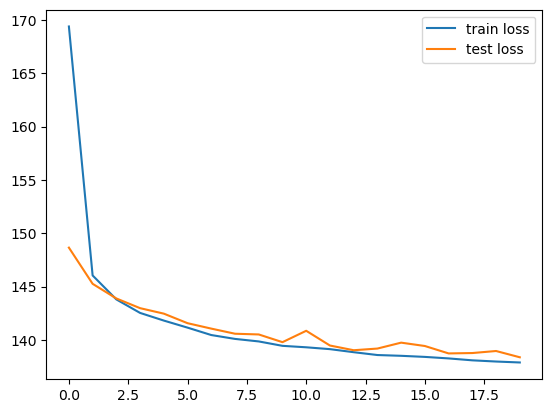

In [7]:
plt.plot(history.train, label="train loss")
plt.plot(history.test, label="test loss")
plt.legend()
plt.show()

In [8]:
# load the saved model
checkpoint = torch.load("best_model.pth", weights_only=True)
model.load_state_dict(checkpoint["model_dict"])
model.training

False

### Reconstruct using the VAE

In [9]:
x, _ = next(iter(loader.test))
with torch.no_grad():
    x_hat, *_ = model(x)
    x_hat = x_hat.cpu()

Example real clothing items


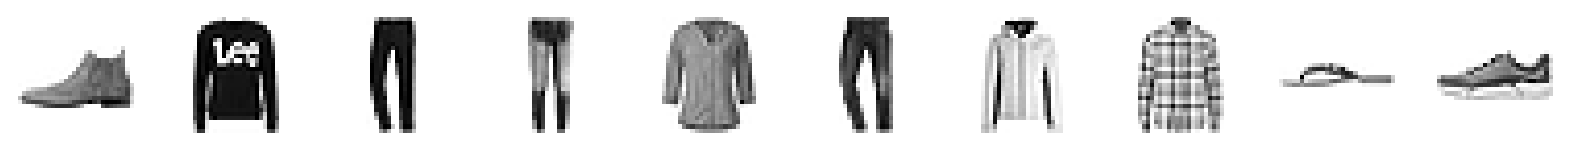

Reconstructions


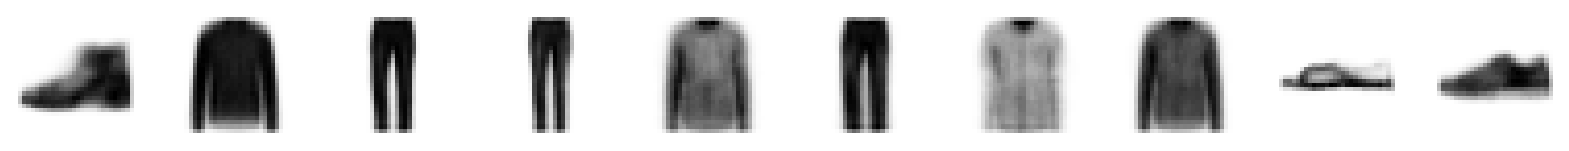

In [10]:
print("Example real clothing items")
display(x)
print("Reconstructions")
display(x_hat)